In [1]:
import os
import sys
sys.path.append(os.getcwd())
sys.path.insert(0, "../porousequivariantnetworks/code/")
sys.path.insert(0, "../porousequivariantnetworks/")


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.ticker as tick

from tqdm import tqdm


from models.equivariant_mpnn import MPNN, MPNNPORE
from utils.ZeoliteData import get_zeolite, get_data_pore, get_data_graph, get_data_megnet
from utils.dataloading import get_data, get_graph_data

#import tueplots 

from models.megnet import MEGNet
from models.cgcnn import CGCNN
from models.schnet import SchNet
from models.dimenet import DimeNetPlusPlus as DimeNet

In [6]:
import matplotlib as mpl

In [7]:
plt.rc('font', family='serif',)

In [8]:
from matplotlib import rc

In [9]:
data = get_zeolite('MOR', True)
    
ref = data['ref'] # reflections
tra = data['tra'] # translations
l = data['l'] # scale of the unit cell

# specific for MOR
atoms, hoa, X, A, d, X_pore, A_pore, d_pore, pore = get_data(l, 'MOR')

edges, idx1, idx2, idx2_oh = get_graph_data(A, d)
edges_sp, idx1_sp, idx2_sp, idx2_oh_sp = get_graph_data(A_pore, d_pore)
edges_ps, idx1_ps, idx2_ps, idx2_oh_ps = get_graph_data(A_pore.T, d_pore.T)

In [10]:
lim=12

In [11]:
trainX = atoms[atoms.sum(1)<lim].sum(1)[:,None]
trainy = hoa[atoms.sum(1)<lim][:,None]
testX = atoms[atoms.sum(1)>=lim].sum(1)[:,None]
testy = hoa[atoms.sum(1)>=lim][:,None]

In [13]:
from sklearn.linear_model import LinearRegression as LR

In [14]:
lr = LR()
lr.fit(trainX, trainy)

LinearRegression()

In [15]:
yhat = lr.predict(testX)

In [16]:
lr_mse, lr_mae = np.mean((testy - yhat)**2), np.mean(np.abs(testy - yhat))

In [18]:
title_size=7.5
label_size=7

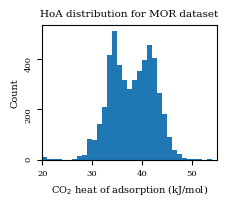

In [19]:
plt.figure(figsize=(2.25,1.75))
plt.hist(hoa, bins=np.arange(20,55,1))
plt.xlabel('CO$_2$ heat of adsorption (kJ/mol)', fontsize=label_size)
plt.ylabel('Count', fontsize=label_size)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6, rotation='vertical')
plt.title('HoA distribution for MOR dataset', fontsize=title_size)
plt.xlim(20,55)
plt.savefig('figures/datadist_mor.pdf', dpi=1200, bbox_inches="tight")
tikzz = plt.xticks()[0]

In [20]:
hoa_x = np.tile(np.linspace(20,55,35)[:,None], (1,12))
hoa_y = np.tile(np.arange(0,12,1)[None], (hoa_x.shape[0],1))

In [21]:
zi = np.zeros((len(hoa_x),12))

for i in range(len(atoms)):
    
    curr_h = hoa[i]
    
    n_als = atoms[i].sum() - 1
    if n_als == -1:
        n_als = 0
              
    for _x in range(0,len(hoa_x)-1):
        
        if hoa_x[_x, n_als] < curr_h <= hoa_x[_x+1, n_als]:
            zi[_x, n_als] += 1

In [23]:
zi = zi/zi.sum(0)[None]

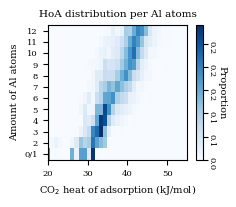

In [24]:
fig, ax = plt.subplots(figsize=(2.25,1.75))
CS = plt.pcolormesh(hoa_x, hoa_y, zi,
                  vmax=zi.max(), vmin=0, cmap='Blues')
#plt.colorbar()
plt.xlabel(f"CO$_2$ heat of adsorption (kJ/mol)", fontsize=label_size)
plt.ylabel(f"Amount of Al atoms", fontsize=label_size)
plt.title("HoA distribution per Al atoms", fontsize=title_size)
cbar = plt.colorbar()
plt.yticks(np.arange(0.,12,1), ['0/1'] + np.arange(2,13,1).tolist(), fontsize=6, rotation='horizontal')
plt.xticks(tikzz)
plt.xticks(fontsize=6)
plt.xlim(20,55)
plt.ylim(-0.5,11.5)
cbar.ax.tick_params(labelsize=6, rotation=270,pad=0)
cbar.ax.get_yaxis().labelpad = 8
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
cbar.set_label('Proportion', rotation=270, fontsize=label_size)
plt.savefig('figures/aldist_mor.pdf', dpi=1200, bbox_inches="tight")

In [25]:
_, testloader, trainloader = get_data_pore(atoms, hoa, edges, pore, edges_sp, edges_ps, bs=32, sub_lim=12)
_, testloader2, trainloader2 = get_data_graph(atoms, hoa, edges, bs=32, sub_lim=12)
_, testloader3, trainloader3 = get_data_megnet(atoms, hoa, edges, bs=32, sub_lim=12)

In [26]:
mpnn = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                    idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                    idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                    hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                    centers=10, mx_d=6, width=1, pool='sum', pool_pore=True).to('cuda')

mpnn2 = MPNN(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, ref, tra,
                        hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                        centers=10, mx_d=6, width=1, pool='sum').to('cuda')
meg = MEGNet(idx1, idx2).cuda()

sch = SchNet(d).cuda()

cgcnn = CGCNN(idx1, idx2).cuda()

dimenet = DimeNet(idx1, idx2, torch.tensor(X), torch.tensor(l)).to('cuda')

In [27]:
def get_95_CI(x):
    
    ci = 1.96*np.std(x)/np.sqrt(len(x))
    return ci

In [31]:
# for j in (range(1,11)):

#     mpnn.load_state_dict(torch.load(f'model_data/MOR/1.0/pore - copy/model_{j}/model.pth'))
#     y_pred, y_true = mpnn.predict(testloader)

#     _mse = ((y_pred - y_true)**2).mean().item()
#     _mae = (y_pred - y_true).abs().mean().item()
#     print(j, _mae, _mse)

In [28]:
#props = [1.]
props = [0.125, .25, .5, .75, 1.]
names = ['pore','equi']

mae_p = []
mse_p = []


mae_e = []
mse_e = []

mae_p_ci = []
mse_p_ci = []


mae_e_ci = []
mse_e_ci = []


mae_s = []
mse_s = []

mae_s_ci = []
mse_s_ci = []


for i in props:
    
    _mae_p = []
    _mse_p = []
    _mae_e = []
    _mse_e = []
    _mae_s = []
    _mse_s = []
    
    for j in tqdm(range(1,11)):
    
        mpnn.load_state_dict(torch.load(f'model_data/MOR/{i}/pore/model_{j}/model.pth'))
        y_pred, y_true = mpnn.predict(testloader)

        _mse = ((y_pred - y_true)**2).mean().item()
        _mae = (y_pred - y_true).abs().mean().item()

        _mae_p.append(_mae)
        _mse_p.append(_mse)

        mpnn2.load_state_dict(torch.load(f'model_data/MOR/{i}/equi/model_{j}/model.pth'))
        y_pred, y_true = mpnn2.predict(testloader2)

        _mse = ((y_pred - y_true)**2).mean().item()
        _mae = (y_pred - y_true).abs().mean().item()

        _mae_e.append(_mae)
        _mse_e.append(_mse)
    
    
        sch.load_state_dict(torch.load(f'model_data/MOR/{i}/schnet/model_{j}/model.pth'))
        y_pred, y_true = sch.predict(testloader2)

        _mse = ((y_pred - y_true)**2).mean().item()
        _mae = (y_pred - y_true).abs().mean().item()

        _mae_s.append(_mae)
        _mse_s.append(_mse)
    
    mae_p.append(np.mean(_mae_p))
    mse_p.append(np.mean(_mse_p))
    mae_e.append(np.mean(_mae_e))
    mse_e.append(np.mean(_mse_e))
    mae_s.append(np.mean(_mae_s))
    mse_s.append(np.mean(_mse_s))

    
    mae_p_ci.append(get_95_CI(_mae_p))
    mse_p_ci.append(get_95_CI(_mse_p))
    mae_e_ci.append(get_95_CI(_mae_e))
    mse_e_ci.append(get_95_CI(_mse_e))
    mae_s_ci.append(get_95_CI(_mae_s))
    mse_s_ci.append(get_95_CI(_mse_s))

    print(i)
    

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.30s/it]


0.125


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.29s/it]


0.25


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.27s/it]


0.5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.28s/it]


0.75


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.31s/it]

1.0


In [29]:
mae_meg = []
mse_meg = []

mae_cg = []
mse_cg = []

mae_dn = []
mse_dn = []

for j in range(1,11):
    
   

    meg.load_state_dict(torch.load(f'model_data/MOR/1.0/megnet/model_{j}/model.pth'))
    y_pred, y_true = meg.predict(testloader3)

    _mse = ((y_pred - y_true)**2).mean().item()
    _mae = (y_pred - y_true).abs().mean().item()

    mae_meg.append(_mae)
    mse_meg.append(_mse)
    
    
    cgcnn.load_state_dict(torch.load(f'model_data/MOR/1.0/cgcnn/model_{j}/model.pth'))
    y_pred, y_true = cgcnn.predict(testloader2)

    _mse = ((y_pred - y_true)**2).mean().item()
    _mae = (y_pred - y_true).abs().mean().item()

    mae_cg.append(_mae)
    mse_cg.append(_mse)

    dimenet.load_state_dict(torch.load(f'model_data/MOR/1.0/dime/model_{j}/model.pth'))
    y_pred, y_true = dimenet.predict(testloader2)

    _mse = ((y_pred - y_true)**2).mean().item()
    _mae = (y_pred - y_true).abs().mean().item()

    mae_dn.append(_mae)
    mse_dn.append(_mse)
    
    
    print(j)
    

1
2
3
4
5
6
7
8
9
10


In [30]:
mae_dn = []
mse_dn = []


for j in range(1,21):
    dimenet.load_state_dict(torch.load(f'model_data/MOR/1.0/dime/model_{j}/model.pth'))
    y_pred, y_true = dimenet.predict(testloader2)

    _mse = ((y_pred - y_true)**2).mean().item()
    _mae = (y_pred - y_true).abs().mean().item()

    mae_dn.append(_mae)
    mse_dn.append(_mse)

In [31]:
mae_dn2 = mae_dn

In [32]:
mae_dn = np.array(mae_dn)[np.argsort(mae_dn2)[:10]].tolist()
mse_dn = np.array(mse_dn)[np.argsort(mae_dn2)[:10]].tolist()

In [33]:
maes = [mae_dn, mae_cg, mae_meg, _mae_s, _mae_e, _mae_p]
mses = [mse_dn, mse_cg, mse_meg, _mse_s, _mse_e, _mse_p]


In [34]:
df = pd.DataFrame(columns = ['MAE','MSE'], index=['Linear Regression','DimeNet++','CGCNN','MEGNet', 'SchNet','Ours (without pores)', 'Ours (with pores)'])
for i in range(len(df.index)):

    if i == 0:
        a = np.round(lr_mae, 3)
        s = np.round(lr_mse, 3)
    else:
        mu_a = np.mean(maes[i-1]).round(3)
        mu_s = np.mean(mses[i-1]).round(3)
        
        ci_a = get_95_CI(maes[i-1]).round(3)
        ci_s = get_95_CI(mses[i-1]).round(3)
        
        
        a = fr'{mu_a} $$\pm$$ {ci_a}'
        s = fr'{mu_s} $$\pm$$ {ci_s}'
        
    df.loc[df.index[i]] = [a,s]

In [35]:
df

,MAE,MSE
Linear Regression,1.862,6.119
DimeNet++,1.751 $$\pm$$ 0.048,5.247 $$\pm$$ 0.23
CGCNN,1.681 $$\pm$$ 0.081,4.967 $$\pm$$ 0.419
MEGNet,1.52 $$\pm$$ 0.053,4.269 $$\pm$$ 0.27
SchNet,1.148 $$\pm$$ 0.049,2.332 $$\pm$$ 0.154
Ours (without pores),1.269 $$\pm$$ 0.094,2.805 $$\pm$$ 0.312
Ours (with pores),1.042 $$\pm$$ 0.037,1.981 $$\pm$$ 0.116


In [36]:
print(df.to_latex(escape=False))

\begin{tabular}{lll}
\toprule
 & MAE & MSE \\
\midrule
Linear Regression & 1.862000 & 6.119000 \\
DimeNet++ & 1.751 $$\pm$$ 0.048 & 5.247 $$\pm$$ 0.23 \\
CGCNN & 1.681 $$\pm$$ 0.081 & 4.967 $$\pm$$ 0.419 \\
MEGNet & 1.52 $$\pm$$ 0.053 & 4.269 $$\pm$$ 0.27 \\
SchNet & 1.148 $$\pm$$ 0.049 & 2.332 $$\pm$$ 0.154 \\
Ours (without pores) & 1.269 $$\pm$$ 0.094 & 2.805 $$\pm$$ 0.312 \\
Ours (with pores) & 1.042 $$\pm$$ 0.037 & 1.981 $$\pm$$ 0.116 \\
\bottomrule
\end{tabular}



In [37]:
np.mean(_mae_p), get_95_CI(_mae_p), np.mean(_mae_s), get_95_CI(_mae_s)

(1.041666615009308,
 0.037141284430479135,
 1.1478869915008545,
 0.04867716742524528)

In [38]:
mae_p = np.array(mae_p)
mse_p = np.array(mse_p)
mae_e = np.array(mae_e)
mse_e = np.array(mse_e)
mae_s = np.array(mae_s)
mse_s = np.array(mse_s)

mae_p_ci = np.array(mae_p_ci)
mse_p_ci = np.array(mse_p_ci)
mae_e_ci = np.array(mae_e_ci)
mse_e_ci = np.array(mse_e_ci)
mae_s_ci = np.array(mae_s_ci)
mse_s_ci = np.array(mse_s_ci)

In [39]:
props2 = np.array(props)*len(trainloader.dataset)

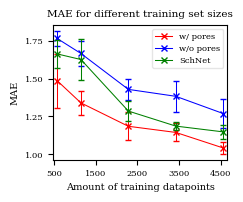

In [62]:
plt.figure(figsize=(2.25,1.75))
plt.plot(props2, mae_p, c='red', label = 'w/ pores', marker='x', markersize=3.75, lw=.75)
plt.errorbar(props2, mae_p, mae_p_ci, c='red', capsize=2.5, fmt='none', lw=.75)
plt.plot(props2, mae_e, c='blue', label = 'w/o pores', marker='x', markersize=3.75, lw=.75)
plt.errorbar(props2, mae_e, mae_e_ci, c ='blue', capsize=2.5, fmt='none', lw=.75)
plt.plot(props2, mae_s, c='green', label = 'SchNet', marker='x', markersize=3.75, lw=.75)
plt.errorbar(props2, mae_s, mae_s_ci,c='green', capsize=2.5, fmt='none', lw=.75)

plt.xlabel('Amount of training datapoints', fontsize=label_size)
plt.ylabel('MAE', fontsize=label_size)
plt.title('MAE for different training set sizes', fontsize=title_size)
plt.legend(fontsize=6, loc='upper right', framealpha=0.5)
plt.xticks(np.arange(500, 5000, 1000), fontsize=6)
plt.yticks(fontsize=6)
plt.xlim(props2.min()-100, props2.max()+100)
plt.savefig('figures/mae2_mor_ext.pdf', dpi=1200, bbox_inches = "tight")

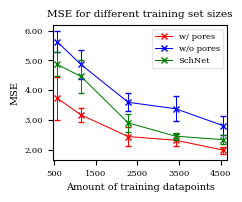

In [41]:
plt.figure(figsize=(2.25,1.75))
plt.plot(props2, mse_p, c='red', label = 'w/ pores', marker='x', markersize=3.75, lw=.75)
plt.errorbar(props2, mse_p, mse_p_ci, c='red', capsize=2.5, fmt='none', lw=.75)
plt.plot(props2, mse_e, c='blue', label = 'w/o pores', marker='x', markersize=3.75, lw=.75)
plt.errorbar(props2, mse_e, mse_e_ci, c ='blue', capsize=2.5, fmt='none', lw=.75)
plt.plot(props2, mse_s, c='green', label = 'SchNet', marker='x', markersize=3.75, lw=.75)
plt.errorbar(props2, mse_s, mse_s_ci,c='green', capsize=2.5, fmt='none', lw=.75)

plt.xlabel('Amount of training datapoints', fontsize=label_size)
plt.ylabel('MSE', fontsize=label_size)
plt.title('MSE for different training set sizes', fontsize=title_size)
plt.legend(fontsize=6, loc='upper right', framealpha=0.5)
plt.xticks(np.arange(500, 5000, 1000), fontsize=6)
plt.yticks(np.arange(2,7,1), ['2.00', '3.00','4.00', '5.00','6.00'], fontsize=6)
plt.xlim(props2.min()-100, props2.max()+100)
plt.savefig('figures/mse2_mor_ext.pdf', dpi=1200, bbox_inches = "tight")


In [42]:
color = np.zeros((X.shape[0],))
for i in range(len(X)):
    
    for j in range(4):
        
        for k in range(ref.shape[0]):
            
            if np.abs(X[i] - (np.mod(ref[k]*X[j] + tra[k], 1))).sum() < 0.001:
                
                color[i] = j
                
                break
        

In [43]:
color2 = np.zeros((X_pore.shape[0],))
for i in range(len(X_pore)):
    
    for j in [0,2,4]:
        
        for k in range(ref.shape[0]):
            
            if np.abs(X_pore[i] - (np.mod(ref[k]*X_pore[j] + tra[k], 1))).sum() < 0.001:
                
                color2[i] = j
                
                break

In [44]:
color2

array([0., 0., 2., 2., 4., 4., 4., 4., 4., 4., 4., 4., 0., 0., 0., 0.])

In [45]:
ce_dict = {}
row, col = np.nonzero(A)
n_c = 0
for i in range(len(row)):
    
    added = False
    
    r,c = row[i], col[i]
    
    for j in ce_dict:
        
        if added: break
        
        test = ce_dict[j][0]
        
        test_r = X[test[0]]
        test_c = X[test[1]]
        
        
        for k in range(ref.shape[0]):
            
            r1 = np.mod(ref[k]*X[r] + tra[k], 1)
            r2 = np.mod(ref[k]*X[c] + tra[k], 1)
            
            if np.abs(r1-test_r).sum() < 0.001 and np.abs(r2-test_c).sum() < 0.001:
                
                ce_dict[j].append((r,c))
                
                added = True
                break
        
    if not added:
        ce_dict[n_c] = [(r,c)]
        n_c += 1

In [46]:
A_pore.shape, A_pore.sum()

((48, 16), 144.0)

In [47]:
cp_dict = {}
row, col = np.nonzero(A_pore)
n_c = 0
for i in range(len(row)):
    
    added = False
    
    r,c = row[i], col[i]
    
    for j in cp_dict:
        
        if added: break
        
        test = cp_dict[j][0]
        
        test_r = X[test[0]]
        test_c = X_pore[test[1]]
        
        
        for k in range(ref.shape[0]):
            
            r1 = np.mod(ref[k]*X[r] + tra[k], 1)
            r2 = np.mod(ref[k]*X_pore[c] + tra[k], 1)
            
            if np.abs(r1-test_r).sum() < 0.001 and np.abs(r2-test_c).sum() < 0.001:
                
                cp_dict[j].append((r,c))
                
                added = True
                break
        
    if not added:
        cp_dict[n_c] = [(r,c)]
        n_c += 1

In [48]:
ce_dict.keys(), cp_dict.keys()

(dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]),
 dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]))

In [49]:
import matplotlib.patheffects as pe

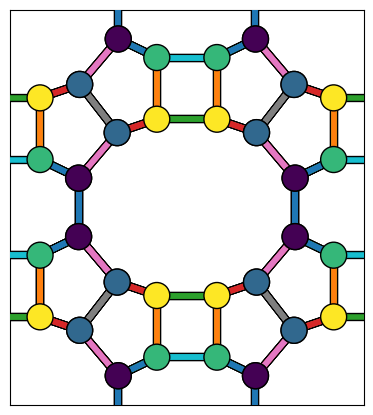

In [50]:
plt.figure(figsize=(18.256/4, 20.534/4))
for i in ce_dict:
    x = 0
    for j in ce_dict[i]:
        
        x1, x2 = X[j[0]].copy(), X[j[1]].copy()
        
        d = x2-x1
        
        for _d in range(3):
            
            if d[_d] > 0.5:
                
                x2[_d] -= 1
            
            elif d[_d] < -.5:
                
                x2[_d] += 1
            
        
        
        
        if x == 0:
            
            line = plt.plot([x1[0], x2[0]], [x1[1], x2[1]], lw=4, zorder=5)
            plt.plot([x1[0], x2[0]], [x1[1], x2[1]], lw=6, c='black', zorder=4)
        
        plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= line[0].get_c(),lw=4, zorder=5)
        plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= 'black',lw=6, zorder=4)
        x+=1
        
        

plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([],[])
plt.yticks([],[])
plt.scatter(X[:,0], X[:,1], c=color, s=350, zorder=10, edgecolors='black')
# plt.scatter(X[:,0], X[:,1], c='black', s=500, zorder=9)
plt.savefig('figures/weight_sharing.svg', bbox_inches='tight', dpi=1200)
plt.savefig('figures/weight_sharing.pdf', bbox_inches='tight', dpi=1200);

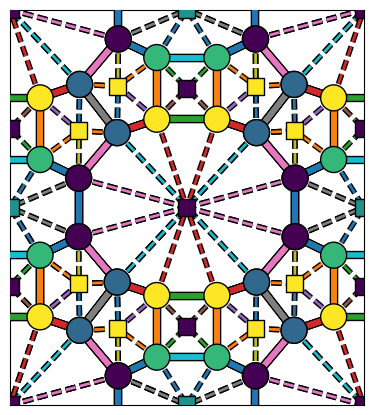

In [51]:
plt.figure(figsize=(18.256/4, 20.534/4))
for i in ce_dict:
    x = 0
    for j in ce_dict[i]:
        
        x1, x2 = X[j[0]].copy(), X[j[1]].copy()
        
        d = x2-x1
        
        for _d in range(3):
            
            if d[_d] > 0.5:
                
                x2[_d] -= 1
            
            elif d[_d] < -.5:
                
                x2[_d] += 1
            
        
        
        
        if x == 0:
            
            line = plt.plot([x1[0], x2[0]], [x1[1], x2[1]], lw=4, zorder=5)
            plt.plot([x1[0], x2[0]], [x1[1], x2[1]], lw=6, c='black', zorder=4)
        
        plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= line[0].get_c(),lw=4, zorder=5)
        plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= 'black',lw=6, zorder=4)
        x+=1
        
        
for i in cp_dict:
    x = 0
    for j in cp_dict[i]:
        
        x1, x2 = X[j[0]].copy(), X_pore[j[1]].copy()
        
        d = x2-x1
        
        for _d in range(3):
            
            if d[_d] > 0.5:
                
                x2[_d] -= 1
            
            elif d[_d] < -.5:
                
                x2[_d] += 1
            
        
        
        
        if x == 0:
            line = plt.plot([x1[0], x2[0]], [x1[1], x2[1]],lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
        
        plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= line[0].get_c(),lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
        #     line = plt.plot([x1[0], x2[0]], [x1[1], x2[1]],lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black')])
        
        # plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= line[0].get_c(),lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black')])
        x+=1
        

plt.scatter(X_pore[:,0], X_pore[:,1], s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.scatter(X_pore[:,0]+1, X_pore[:,1], s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.scatter(X_pore[:,0], X_pore[:,1]+1, s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.scatter(X_pore[:,0]+1, X_pore[:,1]+1, s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([],[])
plt.yticks([],[])
plt.scatter(X[:,0], X[:,1], c=color, s=350, zorder=10, edgecolors='black')
# plt.scatter(X[:,0], X[:,1], c='black', s=500, zorder=9)
plt.savefig('figures/weight_sharing_pore.svg', bbox_inches='tight', dpi=1200)
plt.savefig('figures/weight_sharing_pore.pdf', bbox_inches='tight', dpi=1200);

In [52]:
best_idx = np.argmin(_mae_p)
mpnn.load_state_dict(torch.load(f'model_data/MOR/1.0/pore/model_{best_idx+1}/model.pth'))
y_pred, y_true = mpnn.predict(testloader)

In [53]:
from scipy.interpolate import griddata

In [54]:
y_pred.min(), y_pred.max(), y_true.min(), y_true.max()

(tensor(35.2148), tensor(48.2503), tensor(34.7277), tensor(53.5986))

In [55]:
Z = torch.ones_like(y_pred)

In [57]:
nn = 60
xmin = 30
xmax = 55
xi = np.linspace(xmin, xmax, nn)
yi = np.linspace(xmin, xmax, nn)

In [58]:
#xi.shape, yi.shape, xi, yi

In [59]:
zi = np.zeros((nn,nn))

for i in range(len(y_pred)):
    
    curr_p = y_pred[i].item()
    curr_t = y_true[i].item()
    
    for _x in range(0,nn-1):
        
        if xi[_x] < curr_p <= xi[_x+1]:
            
            for _y in range(0,nn-1):
                
                if yi[_y] < curr_t <= xi[_y+1]:
                    
                    zi[_x,_y] += 1

In [60]:
n_colors = int(zi.max())

C:\Users\20175552\AppData\Local\Temp\ipykernel_20456\1559348101.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues', n_colors+1)


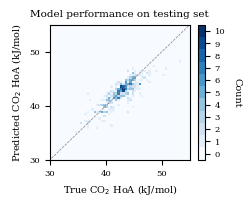

In [61]:
fig, ax = plt.subplots(figsize=(2.25,1.75))
cmap = plt.cm.get_cmap('Blues', n_colors+1)
CS = plt.pcolormesh(xi, yi, zi,
                  vmax=zi.max(), vmin=0, cmap=cmap)
plt.xlabel(f"True CO$_2$ HoA (kJ/mol)", fontsize=label_size)
plt.ylabel(f"Pred. CO$_2$ HoA (kJ/mol)", fontsize=label_size)
plt.title("Model performance on testing set", fontsize=title_size)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".5", lw=.5)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 12
cbar.set_label('Count', rotation=270, fontsize=label_size)
cbar.ax.get_yaxis().set_ticks(np.arange(n_colors/(2*(n_colors+1)), n_colors, n_colors/(n_colors+1)), np.arange(n_colors+1) )
cbar.ax.tick_params(labelsize=6)
plt.xticks(plt.yticks()[0])
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)

plt.savefig('figures/truepred_mor_ext.pdf', dpi=1200, bbox_inches="tight")